In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os


#create dataset directory
data_dir = "/content/drive/MyDrive/fisrt model"
images_dir = os.path.join(data_dir, "DATA SET")

In [46]:
test_dir =os.path.join(data_dir,"free data sets")
model_classes = os.listdir(test_dir)
model_classes

['Salmo', 'Ncd', 'cocci', 'Healthy']

In [4]:
images_dir

'/content/drive/MyDrive/fisrt model/DATA SET'

In [63]:
model_classes = os.listdir(images_dir)

In [64]:
model_classes

['ncd', 'healthy', 'cocci', 'salmo']

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



Class: ncd, Images Found: 338


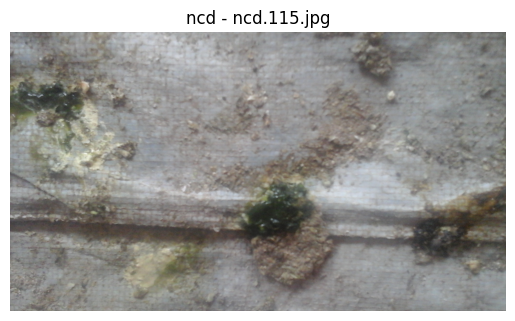

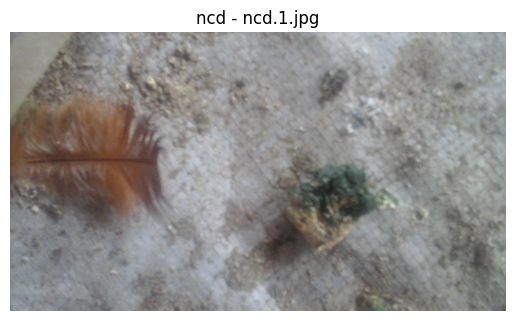

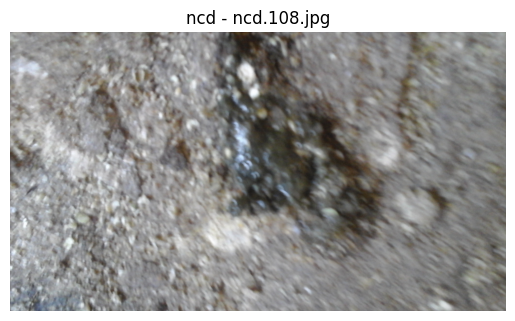

Class: healthy, Images Found: 1857


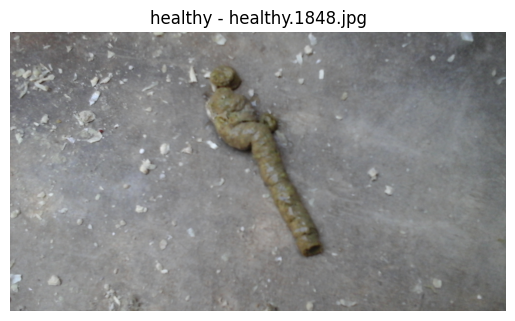

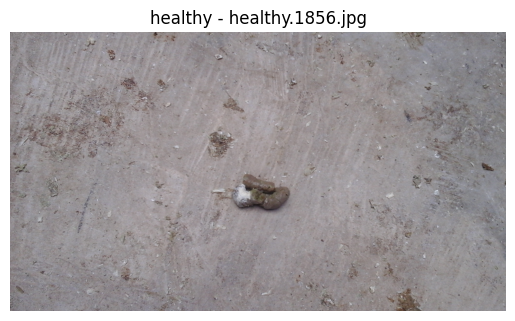

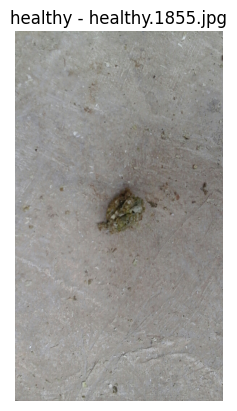

Class: cocci, Images Found: 1903


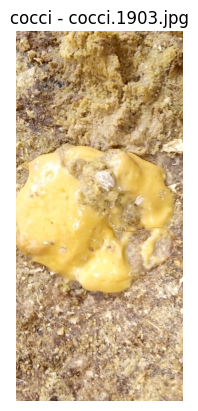

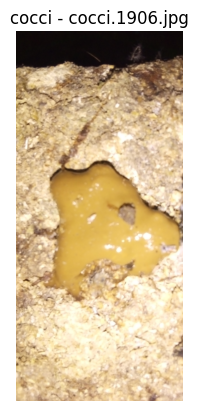

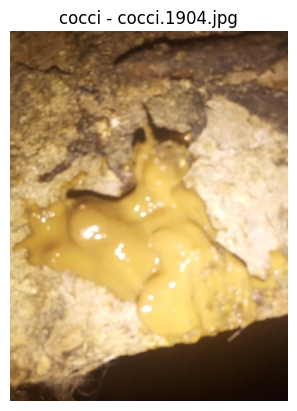

Class: salmo, Images Found: 2086


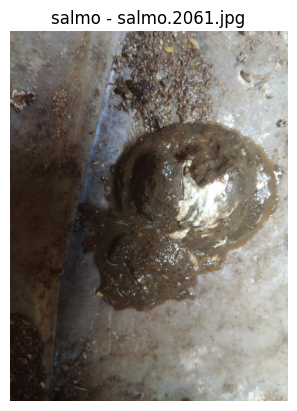

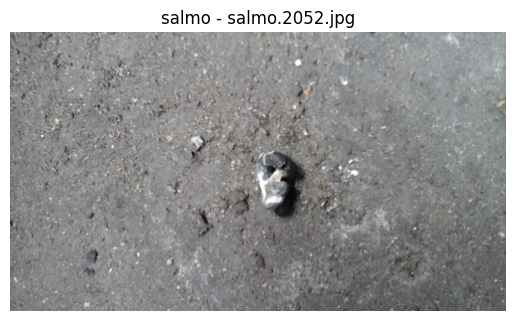

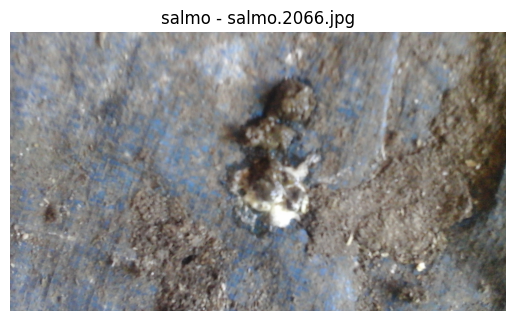

In [8]:
import os
import glob
import matplotlib.pyplot as plt
import cv2

# Path to the train dataset
train_dir = os.path.join(data_dir, "DATA SET")

# Get all class folders (disease categories or image classes)
class_folders = os.listdir(train_dir)

# Iterate through each class folder
for class_name in class_folders:
    class_path = os.path.join(train_dir, class_name)  # Full path to the class folder

    # Get all image files inside the class folder
    image_paths = glob.glob(os.path.join(class_path, "*.jpg"))  # Adjust extension if needed

    print(f"Class: {class_name}, Images Found: {len(image_paths)}")  # Print class name and number of images

    # Display a few images from each class
    for img_path in image_paths[:3]:  # Display only the first 3 images from each class
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

        plt.imshow(img)  # Show image
        plt.title(f"{class_name} - {os.path.basename(img_path)}")  # Title with class name
        plt.axis("off")  # Hide axes
        plt.show()  # Display image


In [9]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define dataset path


# Define transformations (augmentation & normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset (Ensure images are inside class subfolders)
dataset = ImageFolder(root=images_dir, transform=transform)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)


Classes: ['cocci', 'healthy', 'ncd', 'salmo']


In [10]:
len(train_dataset), len(test_dataset)

(4947, 1237)

In [11]:
# model = models.mobilenet_v2(pretrained=True)


In [61]:
import torchvision.models as models
import torch.nn as nn

# Load EfficientNet-B0 model (pretrained on ImageNet)
model = models.efficientnet_b0(pretrained=True)

# Modify classifier head
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(dataset.classes))  # Output size = number of classes
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Classification loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust LR if needed


In [14]:
def Accuracy_fn(y_true: torch.tensor, y_pred:torch.tensor):
  if y_pred.ndim >1 and y_pred.shape[1] > 1:
    y_pred = torch.argmax(y_pred, dim=1)

  y_true = y_true.view(-1)

  corrects = torch.eq(y_true, y_pred).sum().item()
  acc = (corrects / len(y_true)) * 100
  return acc

In [15]:
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)

from tqdm import tqdm

epochs = 5

for epoch in range(epochs):
  print(f"Epoch: {epoch+1}/{epochs}.......................")
  model.train()

  train_loss = 0
  train_accuracy = 0

  for batch, (x_true, y_true) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
    x_true, y_true = x_true.to(device), y_true.to(device)
    model.train()

    # print(f"Input shape before model: {x_true.shape}")


    y_pred = model(x_true)
    #print(f"output shape after model: {y_pred.shape}")

    loss = criterion(y_pred,y_true)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    with torch.no_grad():
      train_accuracy += Accuracy_fn(y_true, y_pred)



  train_loss /= len(train_loader)  # Normalize loss
  train_accuracy /= len(train_loader)  # Normalize accuracy

  print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")




Epoch: 1/5.......................


Epoch 1: 100%|██████████| 155/155 [48:43<00:00, 18.86s/it]


Train Loss: 0.4087 | Train Accuracy: 89.05%
Epoch: 2/5.......................


Epoch 2: 100%|██████████| 155/155 [26:41<00:00, 10.33s/it]


Train Loss: 0.0884 | Train Accuracy: 97.65%
Epoch: 3/5.......................


Epoch 3: 100%|██████████| 155/155 [26:34<00:00, 10.29s/it]


Train Loss: 0.0462 | Train Accuracy: 98.59%
Epoch: 4/5.......................


Epoch 4: 100%|██████████| 155/155 [26:35<00:00, 10.29s/it]


Train Loss: 0.0301 | Train Accuracy: 98.85%
Epoch: 5/5.......................


Epoch 5: 100%|██████████| 155/155 [26:44<00:00, 10.35s/it]

Train Loss: 0.0252 | Train Accuracy: 99.25%


In [16]:
torch.save(model.state_dict(), "model_weights.pth")

In [17]:
torch.save(model, "model1.pth")

In [19]:
model = torch.load("/content/model1.pth")
# model.to("cuda")

<ipython-input-19-cb5a6d4a1e16>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/model1.pth")


In [24]:
import torch
from tqdm.auto import tqdm

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define number of epochs
epochs = 5

# Set model to evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}.......................")

        test_accuracy = 0
        test_loss = 0

        for batch, (images, labels) in tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing Progress"):
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()  # Use .item() to get scalar value

            # Compute accuracy
            test_accuracy += Accuracy_fn(labels, outputs)

        # Calculate average loss and accuracy
        test_accuracy /= len(test_loader)
        test_loss /= len(test_loader)

        # Print results for the epoch
        print(f"Test Accuracy: {test_accuracy:.4f}% | Test Loss: {test_loss:.4f}")


Epoch: 1/5.......................


Testing Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 98.5577% | Test Loss: 0.0479
Epoch: 2/5.......................


Testing Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 97.9968% | Test Loss: 0.0533
Epoch: 3/5.......................


Testing Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 98.3974% | Test Loss: 0.0520
Epoch: 4/5.......................


Testing Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 97.9968% | Test Loss: 0.0554
Epoch: 5/5.......................


Testing Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 98.4776% | Test Loss: 0.0471


In [25]:
torch.save(model.state_dict(), "efficientnet_chicken_disease_updated.pth")
print("Model saved successfully!")


Model saved successfully!


In [26]:
torch.save(model, "efficientnet_chicken_disease_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [67]:
import torch
import torchvision.transforms as transforms
from PIL import Image
model.load_state_dict(torch.load("/content/efficientnet_chicken_disease_updated.pth", map_location=device))
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the trained model (if not already loaded)
model.to(device)
model.eval()

# Define the transformation (must match training transformations)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model's expected input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (adjust as per training data)
])

def predict_image(image_path, model, classes):
    """Performs inference on a single image."""

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as model
    image = image.to(device)

    # Disable gradients for inference
    with torch.no_grad():
        output = model(image)  # Forward pass
        _, predicted_class = torch.max(output, 1)  # Get class with highest probability

    # Convert prediction to class label
    predicted_label = classes[predicted_class.item()]

    return predicted_label


# Example usage

image_path = "path/to/image.jpg"  # Provide the path to your image

predicted_label = predict_image("/content/drive/MyDrive/fisrt model/DATA SET/healthy/healthy.1002.jpg", model, model_classes)
print(f"Predicted Class: {predicted_label}")


<ipython-input-67-db368d25311a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/efficientnet_chicken_disease_updated.pth", map_lo

Predicted Class: healthy


In [48]:
model_classes

['Salmo', 'Ncd', 'cocci', 'Healthy']

In [71]:
def predict_from_dataloader(model, test_loader, classes, num_samples=32):
    """Predicts labels for a few images from the test set."""

    model.eval()
    images, labels = next(iter(test_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Display results
    for i in range(num_samples):
        print(f"Actual: {classes[labels[i].item()]}, Predicted: {classes[preds[i].item()]}")

# Example usage
predict_from_dataloader(model, test_loader, model_classes)


Actual: salmo, Predicted: salmo
Actual: ncd, Predicted: ncd
Actual: healthy, Predicted: healthy
Actual: ncd, Predicted: ncd
Actual: salmo, Predicted: salmo
Actual: ncd, Predicted: ncd
Actual: salmo, Predicted: salmo
Actual: ncd, Predicted: ncd
Actual: ncd, Predicted: ncd
Actual: salmo, Predicted: salmo
Actual: healthy, Predicted: healthy
Actual: healthy, Predicted: healthy
Actual: healthy, Predicted: healthy
Actual: ncd, Predicted: ncd
Actual: ncd, Predicted: ncd
Actual: healthy, Predicted: healthy
Actual: salmo, Predicted: salmo
Actual: healthy, Predicted: healthy
Actual: healthy, Predicted: healthy
Actual: ncd, Predicted: ncd
Actual: healthy, Predicted: healthy
Actual: salmo, Predicted: salmo
Actual: healthy, Predicted: healthy
Actual: salmo, Predicted: salmo
Actual: ncd, Predicted: ncd
Actual: ncd, Predicted: ncd
Actual: healthy, Predicted: healthy
Actual: ncd, Predicted: ncd
Actual: cocci, Predicted: cocci
Actual: salmo, Predicted: salmo
Actual: healthy, Predicted: healthy
Actual: 